# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Problem Statement:

At a leading electronics company, ‘SG Electrics' which manufactures state of the art Smart Televisions. As an addition to the smart features of the televisions, you are given the responsibility to develop a model that can recognise 5 different gestures listed below which will help the customers in navigating through the SMART TV without using the remote. 

1. Thumbs Up: Increase the volume

2. Thumbs Down: Lower the volume

3. Left Swipe: Fast Forward 10 seconds

4. Right Swipe: Fast Backward 10 seconds

5. Stop: Pause the movie

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import abc

def imread(path):
    from PIL import Image
    return np.array(Image.open(path))

def imresize(img, size):
    from PIL import Image
    return np.array(Image.fromarray(img).resize(size))

In [2]:
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
pip install numpy==1.19.5

Note: you may need to restart the kernel to use updated packages.


*Data Exploration*

In [7]:
# Getting current directory 
curr_directory = os.getcwd()

# Path to the project file 
project_data_path = "Project_data"

train_data_folder_loc = "/train"

# path to the CSV
train_csvfile_loc = "train.csv"

# Final path 
train_csv_path = os.path.join(curr_directory, project_data_path, train_csvfile_loc)

# Storing the size of images size     
s = []

# stroring images for imread
collected_images = []

# Reading each line in CSV
with open(train_csv_path) as f:
    lines = f.readlines()

# Exctract each image from the "train" folder in "Project_data"
for line in lines:
    
    data_folder = project_data_path + train_data_folder_loc +"/"+ line.split(';')[0]+"/"

    folder_images = os.listdir(data_folder)
    
    for img in folder_images:
        
        each_img_name = data_folder + "/" + img
        
        single_image = imread(each_img_name)
        
        # Appending the image shape to "s"
        s.append(single_image.shape)
        
        # Appending the image location for imread to "collected_images"
        collected_images.append(each_img_name)

In [8]:
# Convert list to dataframe 
df_s = pd.DataFrame(s,columns=['height','width','channels'])

# Viewing the dataframe 
df_s.head()

,height,width,channels
0,120,160,3
1,120,160,3
2,120,160,3
3,120,160,3
4,120,160,3


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D ,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras import optimizers


In [10]:
from tensorflow.keras.layers import LSTM

In [11]:
## We have changed the right path where the files are stored above.

train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 40 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [27]:
##Generator function for input data without augmentation.

x = 30 # No. of frames images
y = 120 # Width of the image
z = 120 # height

def generator(source_path, folder_list, batch_size):
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Let us resize all the images.Let's use PIL.Image.NEAREST (use nearest neighbour) resampling filter. 
                    resized_image = imresize(image,(y,z)) ##default resample=1 or 'P' which indicates PIL.Image.NEAREST
                    resized_image = resized_image.astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/127.5-1#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/127.5-1#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/127.5-1#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches        
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = imresize(image,(y,z)) ##default resample=1 or 'P' which indicates PIL.Image.NEAREST
                    resized_image = resized_image.astype(np.float32) #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/127.5-1
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/127.5-1
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/127.5-1
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# Training_Sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation_Sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# Epochs = ', num_epochs)

# Training_Sequences = 663
# Validation_Sequences = 100
# Epochs =  30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Model 1 : (Conv3D 1 layer + Dense 1 layer) ( Dropout : 50% ,  dense_nurons : (1000,50) optimiser : Adam , batch_size: 40, Augment: False)

In [14]:
model_1 = Sequential()       
#model_1.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, 160, 160, 3),padding='same'))
#model_1.add(BatchNormalization())
#model_1.add(Activation('relu'))

model_1.add(Conv3D(16, (3, 3, 3),input_shape=(30, 120, 120, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_1.add(Conv3D(32, (2, 2, 2), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_1.add(Conv3D(64, (2, 2, 2), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_1.add(Conv3D(128, (2, 2, 2), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))      

# Flatten layer 

model_1.add(Flatten())

model_1.add(Dense(1000, activation='relu',kernel_regularizer='l2'))
model_1.add(Dropout(0.5))

model_1.add(Dense(500, activation='relu',kernel_regularizer='l2'))
model_1.add(Dropout(0.5))

#Softmax layer

model_1.add(Dense(5, activation='softmax',kernel_regularizer='l2'))

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [15]:
optimiser = optimizers.Adam()#(lr=0.001) #write your optimizer
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 60, 60, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 32)    0

In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
# Let us see the Validate the Losses and put back the checkpoint

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [29]:
# Let us see that the steps_per_epoch and validation steps are used by fit_generator to decide the no. of next()

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
# Let us fit the model

model_1 = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - 69s 4s/step - loss: 29.7617 - categorical_accuracy: 0.2368 - val_loss: 20.9424 - val_categorical_accuracy: 0.1800

Epoch 00001: val_categorical_accuracy improved from -inf to 0.18000, saving model to model_init_2022-04-1919_08_45.204484/model-00001-26.97218-0.27149-20.94242-0.18000.h5
Epoch 2/30
17/17 [==============================] - 40s 2s/step - loss: 19.8347 - categorical_accuracy: 0.3861 - val_loss: 16.6293 - val_categorical_accuracy: 0.2833

Epoch 00002: val_categorical_accuracy improved from 0.18000 to 0.28333, saving model to model_init_2022-04-1919_08_45.204484/model-00002-18.77052-0.39898-16.62930-0.28333.h5
Epoch 3/30
17/17 [==============================] - 37s 2s/step - loss: 15.5886 - categorical_accuracy: 0.4572 - val_loss: 13.5230 - val_categorical_accuracy: 0.6167

Epoch 00003: val_categorical_accuracy improved from 0.28333 to 0.61667, saving model to model_init_2022-04-1919_08_45.204484/model-00003-14.95149-0.44414-

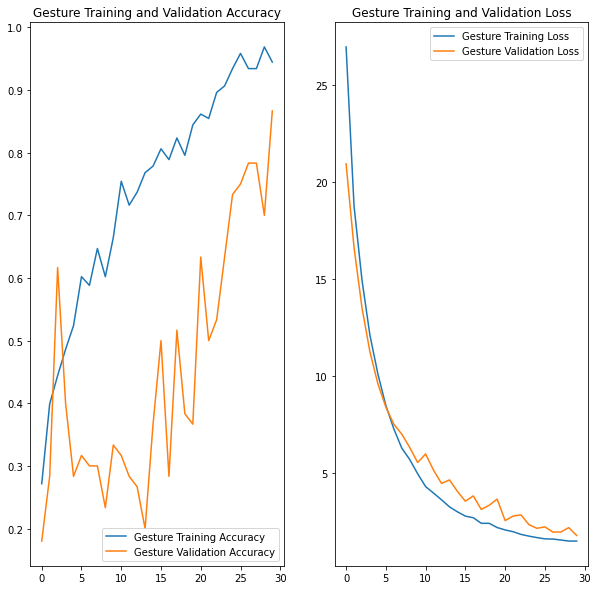

Max. Training Accuracy 0.9688581228256226
Max. Validaiton Accuracy 0.8666666746139526


In [20]:
#Declaring Accuracy
gesture_accuracy = model_1.history['categorical_accuracy']

gesture_valid_accuracy = model_1.history['val_categorical_accuracy']

#Declaring Loss
gesture_loss = model_1.history['loss']

gesture_valid_loss = model_1.history['val_loss']

epochs_range = range(num_epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,gesture_accuracy,label='Gesture Training Accuracy')
plt.plot(epochs_range,gesture_valid_accuracy,label='Gesture Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Gesture Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,gesture_loss,label='Gesture Training Loss')
plt.plot(epochs_range,gesture_valid_loss,label='Gesture Validation Loss')
plt.legend(loc='upper right')
plt.title("Gesture Training and Validation Loss")

plt.show()

print("Max. Training Accuracy", max(model_1.history['categorical_accuracy']))
print("Max. Validaiton Accuracy", max(model_1.history['val_categorical_accuracy']))

<p><b>Final Verdicts :</b></p>
<p><b>Model : </b>Conv3D 3 layer + Dense 1 layer</p>
<p><b>Verdict :</b>The train accuracy given here performed highest at 74% and max test accuracy is at 60% we can also observe that at the 8th epoch the system was having a fair categorization of 60% in both train and test we can also observe the similar anamoly at the loss of 8th epoch.</p>
<br>
<p><b>Performance Metrics :</b></p>
<ul>
    <li>Max Training Accuracy : 96%</li>
    <li>Max Validation Accuracy : 86%</li>
</ul>

#### Model 2 : (Conv3D 1 layer + Dense 1 layer) ( Dropout : 50% ,  dense_nurons : (128,64) optimiser :SGD , batch_size: 40, Augment: False)

In [21]:
# Input all the images sequencial by building the layer with dropouts and batchnormalisation

model_2 = Sequential()       
#model_2.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, 160, 160, 3),padding='same'))
#model_2.add(BatchNormalization())
#model_2.add(Activation('elu'))

model_2.add(Conv3D(16, (3, 3, 3),input_shape=(30, 120, 120, 3), padding='same'))
model_2.add(Activation('elu'))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(32, (2, 2, 2), padding='same'))
model_2.add(Activation('elu'))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(64, (2, 2, 2), padding='same'))
model_2.add(Activation('elu'))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(128, (2, 2, 2), padding='same'))
model_2.add(Activation('elu'))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))      

# Flatten layer 

model_2.add(Flatten())

model_2.add(Dense(128, activation='elu',kernel_regularizer='l1'))
model_2.add(Dropout(0.5))

model_2.add(Dense(64, activation='elu',kernel_regularizer='l1'))
model_2.add(Dropout(0.25))

#Softmax layer

model_2.add(Dense(5, activation='softmax'))

# Let us use the Adam optimiser 

optimiser =optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_5 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 7, 30, 30, 64)    

In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
model_2 = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - 67s 4s/step - loss: 130.6786 - categorical_accuracy: 0.2083 - val_loss: 127.3680 - val_categorical_accuracy: 0.2600

Epoch 00001: val_categorical_accuracy did not improve from 0.86667
Epoch 2/30
17/17 [==============================] - 39s 2s/step - loss: 126.2658 - categorical_accuracy: 0.2648 - val_loss: 122.8392 - val_categorical_accuracy: 0.3167

Epoch 00002: val_categorical_accuracy did not improve from 0.86667
Epoch 3/30
17/17 [==============================] - 37s 2s/step - loss: 121.7849 - categorical_accuracy: 0.3017 - val_loss: 118.4406 - val_categorical_accuracy: 0.3333

Epoch 00003: val_categorical_accuracy did not improve from 0.86667
Epoch 4/30
17/17 [==============================] - 34s 2s/step - loss: 117.2907 - categorical_accuracy: 0.4003 - val_loss: 114.0992 - val_categorical_accuracy: 0.3500

Epoch 00004: val_categorical_accuracy did not improve from 0.86667
Epoch 5/30
17/17 [==============================] - 33s 

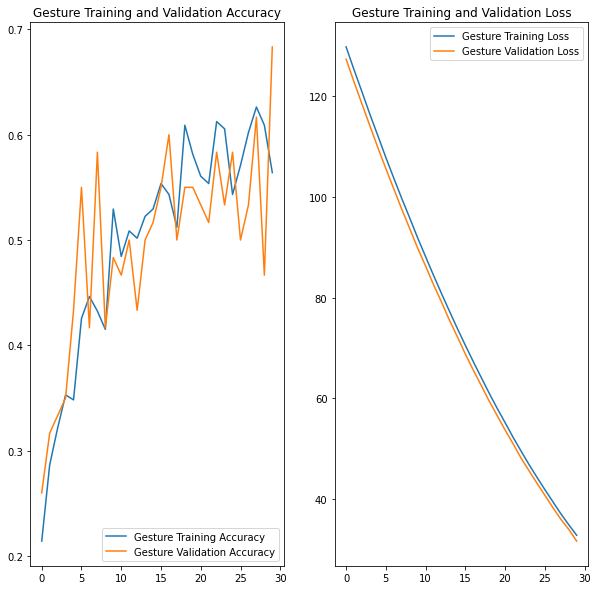

Max. Training Accuracy 0.6262975931167603
Max. Validaiton Accuracy 0.6833333373069763


In [24]:
#Declaring Accuracy
gesture_accuracy = model_2.history['categorical_accuracy']

gesture_valid_accuracy = model_2.history['val_categorical_accuracy']

#Declaring Loss
gesture_loss = model_2.history['loss']

gesture_valid_loss = model_2.history['val_loss']

epochs_range = range(num_epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,gesture_accuracy,label='Gesture Training Accuracy')
plt.plot(epochs_range,gesture_valid_accuracy,label='Gesture Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Gesture Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,gesture_loss,label='Gesture Training Loss')
plt.plot(epochs_range,gesture_valid_loss,label='Gesture Validation Loss')
plt.legend(loc='upper right')
plt.title("Gesture Training and Validation Loss")

plt.show()

print("Max. Training Accuracy", max(model_2.history['categorical_accuracy']))
print("Max. Validaiton Accuracy", max(model_2.history['val_categorical_accuracy']))

<p><b>Final Verdicts :</b></p>
<p><b>Model : </b>Conv3D 1 layer + Dense 1 layer + SGD</p>
<p><b>Verdict :</b>The train accuracy given here performed highest at 62% and max test accuracy is at 60% we can also observe that at the 30th epoch the system was having a fair categorization of 68% in both test we can also observe the similar anamoly at the loss of 30th epoch.</p>
<br>
<p><b>Performance Metrics :</b></p>
<ul>
    <li>Max Training Accuracy : 62%</li>
    <li>Max Validation Accuracy : 68%</li>
</ul>

#### Model 3 : (Conv3D 1 layer + Dense 2 layer) ( Dropout : 50% and 25% ,  dense_nurons : (128,64) optimiser : Adam , batch_size: 40, Augment: False)

In [25]:
# Let us experiment different x,y,z value in the CNN network and find tune all the image size & Hyperparameters later

x = 30 # number of frames
y = 120 # image width
z = 120 # image height

# Input all the images sequencial by building the layer with dropouts and batchnormalisation

model_3 = Sequential()       

model_3.add(Conv3D(16, (3, 3, 3), input_shape=(x,y,z,3),padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3.add(Conv3D(32, (2, 2, 2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3.add(Conv3D(64, (2, 2, 2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3.add(Conv3D(128, (2, 2, 2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))      

# Flatten layer 

model_3.add(Flatten())

model_3.add(Dense(128, activation='relu' , kernel_regularizer='l2'))
model_3.add(Dropout(0.5))

model_3.add(Dense(64, activation='relu' , kernel_regularizer='l2'))
model_3.add(Dropout(0.25))

#Softmax layer

model_3.add(Dense(5, activation='softmax'))

# Let us use the Adam optimiser 

optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_9 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 7, 30, 30, 64)    

In [26]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [27]:
model_3 = model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - 67s 4s/step - loss: 4.4323 - categorical_accuracy: 0.1981 - val_loss: 3.0451 - val_categorical_accuracy: 0.2000

Epoch 00001: val_categorical_accuracy did not improve from 0.86667
Epoch 2/30
17/17 [==============================] - 39s 2s/step - loss: 2.8314 - categorical_accuracy: 0.2331 - val_loss: 2.3232 - val_categorical_accuracy: 0.2333

Epoch 00002: val_categorical_accuracy did not improve from 0.86667
Epoch 3/30
17/17 [==============================] - 37s 2s/step - loss: 2.3331 - categorical_accuracy: 0.2140 - val_loss: 2.1316 - val_categorical_accuracy: 0.3500

Epoch 00003: val_categorical_accuracy did not improve from 0.86667
Epoch 4/30
17/17 [==============================] - 34s 2s/step - loss: 2.0762 - categorical_accuracy: 0.2705 - val_loss: 1.8422 - val_categorical_accuracy: 0.2833

Epoch 00004: val_categorical_accuracy did not improve from 0.86667
Epoch 5/30
17/17 [==============================] - 34s 2s/step - loss: 

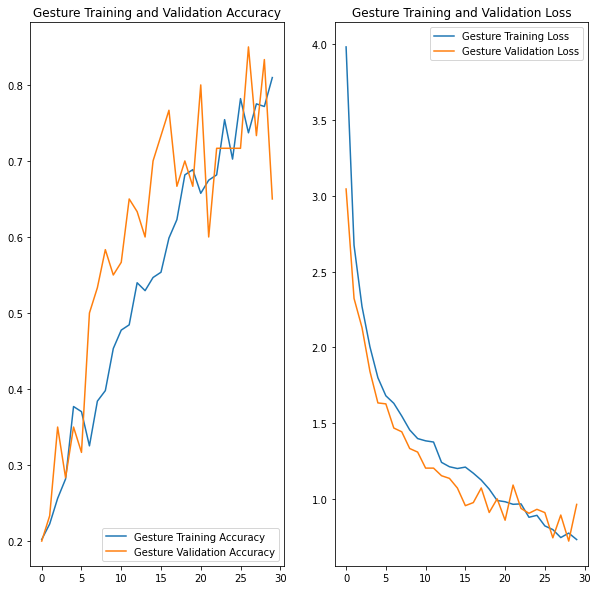

Max. Training Accuracy 0.8096885681152344
Max. Validaiton Accuracy 0.8500000238418579


In [28]:
#Declaring Accuracy
gesture_accuracy = model_3.history['categorical_accuracy']

gesture_valid_accuracy = model_3.history['val_categorical_accuracy']

#Declaring Loss
gesture_loss = model_3.history['loss']

gesture_valid_loss = model_3.history['val_loss']

epochs_range = range(num_epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,gesture_accuracy,label='Gesture Training Accuracy')
plt.plot(epochs_range,gesture_valid_accuracy,label='Gesture Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Gesture Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,gesture_loss,label='Gesture Training Loss')
plt.plot(epochs_range,gesture_valid_loss,label='Gesture Validation Loss')
plt.legend(loc='upper right')
plt.title("Gesture Training and Validation Loss")

plt.show()

print("Max. Training Accuracy", max(model_3.history['categorical_accuracy']))
print("Max. Validaiton Accuracy", max(model_3.history['val_categorical_accuracy']))

<p><b>Final Verdicts :</b></p>
<p><b>Model : </b>Conv3D 4 layer + Dense 2 layer + SGD</p>
<p><b>Verdict :</b>The train accuracy given here performed highest at 81% and max test accuracy is at 85% we can also observe that at the 27th epoch the system was having a fair categorization of 85% in  test we can also observe the similar anamoly at the loss of 10th epoch.</p>
<br>
<p><b>Performance Metrics :</b></p>
<ul>
    <li>Max Training Accuracy : 81%</li>
    <li>Max Validation Accuracy : 85%</li>
</ul>

#### Model 4 : (Conv3D 4 layer + Dense 1 layer) ( Dropout : 50% , 55%,  dense_nurons : (1000,50) optimiser : Adam , batch_size: 40, Augment: False)

In [29]:
# Let us experiment different x,y,z value in the CNN network and find tune all the image size & Hyperparameters later

x = 30 # number of frames
y = 160 # image width
z = 160 # image height

# Input all the images sequencial by building the layer with dropouts and batchnormalisation

model_4 = Sequential()       

model_4.add(Conv3D(16, (3, 3, 3), input_shape=(x,y,z,3),padding='same'))
model_4.add(Activation('relu'))
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_4.add(Conv3D(32, (2, 2, 2), padding='same'))
model_4.add(Activation('relu'))
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_4.add(Conv3D(64, (2, 2, 2), padding='same'))
model_4.add(Activation('relu'))
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_4.add(Conv3D(128, (2, 2, 2), padding='same'))
model_4.add(Activation('relu'))
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))      

# Flatten layer 

model_4.add(Flatten())

model_4.add(Dense(1000, activation='relu',kernel_regularizer='l2'))
model_4.add(Dropout(0.5))

model_4.add(Dense(500, activation='relu',kernel_regularizer='l2'))
model_4.add(Dropout(0.55))

#Softmax layer

model_4.add(Dense(5, activation='softmax'))

# Let us use the Adam optimiser 

optimiser = optimizers.Adam(lr=0.002) #write your optimizer
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 30, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_13 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 7, 40, 40, 32)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 7, 40, 40, 64)    

In [30]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [31]:
model_4 = model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30,verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - 80s 5s/step - loss: 16.3625 - categorical_accuracy: 0.2313 - val_loss: 4.7978 - val_categorical_accuracy: 0.2300

Epoch 00001: val_categorical_accuracy did not improve from 0.86667
Epoch 2/30
17/17 [==============================] - 49s 3s/step - loss: 3.9475 - categorical_accuracy: 0.2579 - val_loss: 2.3998 - val_categorical_accuracy: 0.2500

Epoch 00002: val_categorical_accuracy did not improve from 0.86667
Epoch 3/30
17/17 [==============================] - 46s 3s/step - loss: 2.2480 - categorical_accuracy: 0.2414 - val_loss: 1.8267 - val_categorical_accuracy: 0.3167

Epoch 00003: val_categorical_accuracy did not improve from 0.86667
Epoch 4/30
17/17 [==============================] - 42s 3s/step - loss: 1.8044 - categorical_accuracy: 0.3312 - val_loss: 1.6582 - val_categorical_accuracy: 0.4500

Epoch 00004: val_categorical_accuracy did not improve from 0.86667
Epoch 5/30
17/17 [==============================] - 39s 2s/step - loss:

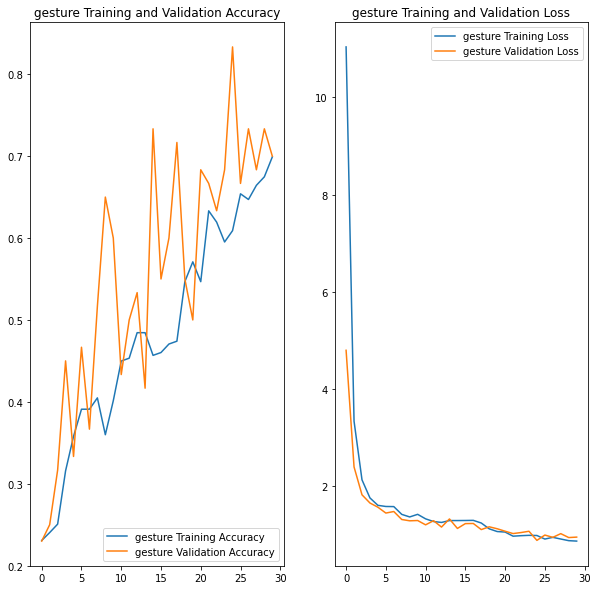

Max. Training Accuracy 0.6989619135856628
Max. Validaiton Accuracy 0.8333333134651184


In [33]:
#Declaring Accuracy
gesture_accuracy = model_4.history['categorical_accuracy']

gesture_valid_accuracy = model_4.history['val_categorical_accuracy']

#Declaring Loss
gesture_loss = model_4.history['loss']

gesture_valid_loss = model_4.history['val_loss']

epochs_range = range(num_epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,gesture_accuracy,label='gesture Training Accuracy')
plt.plot(epochs_range,gesture_valid_accuracy,label='gesture Validation Accuracy')
plt.legend(loc='lower right')
plt.title("gesture Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,gesture_loss,label='gesture Training Loss')
plt.plot(epochs_range,gesture_valid_loss,label='gesture Validation Loss')
plt.legend(loc='upper right')
plt.title("gesture Training and Validation Loss")

plt.show()

print("Max. Training Accuracy", max(model_4.history['categorical_accuracy']))
print("Max. Validaiton Accuracy", max(model_4.history['val_categorical_accuracy']))

<p><b>Final Verdicts :</b></p>
<p><b>Model : </b>Conv3D 4 layer + Dense 1 layer </p>
<p><b>Verdict :</b>The train accuracy given here performed highest at 68% and max test accuracy is at 83% which is showing underfitting</p>
<br>
<p><b>Performance Metrics :</b></p>
<ul>
    <li>Max Training Accuracy : 68%</li>
    <li>Max Validation Accuracy : 83%</li>
</ul>

#### Model 5 : (Conv2D 5 layer + LSTM RNN 1 layer) ( Dropout : 25% ,  dense_nurons : 64, optimiser : ADAM , batch_size: 40, Augment: False)

In [34]:
# Let us experiment different x,y,z value in the CNN network and find tune all the image size & Hyperparameters later

x = 30 # number of frames
y = 120 # image width
z = 120 # image height


# Input all the images sequencial by building the layer with dropouts

model_5 = Sequential()       

model_5.add(TimeDistributed(Conv2D(16, (3, 3), input_shape=(x,y,z,3),padding='same',activation='relu')))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model_5.add(TimeDistributed(Conv2D(32, (3,3), padding='same',activation='relu')))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model_5.add(TimeDistributed(Conv2D(64, (3,3), padding='same',activation='relu')))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model_5.add(TimeDistributed(Conv2D(128, (3,3), padding='same',activation='relu')))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model_5.add(TimeDistributed(Conv2D(256, (3,3), padding='same',activation='relu')))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Flatten layer 

model_5.add(TimeDistributed(Flatten()))

model_5.add(LSTM(64))
model_5.add(Dropout(0.25))

model_5.add(Dense(64, activation='relu'))
model_5.add(Dropout(0.25))

#Softmax layer

model_5.add(Dense(5, activation='softmax'))

# Let us use the Adam optimiser 

optimiser = optimizers.Adam() #write your optimizer
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_5.build(input_shape=(30,30,160,160,3))
print(model_5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (30, 30, 160, 160, 16)    448       
_________________________________________________________________
time_distributed_1 (TimeDist (30, 30, 80, 80, 16)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (30, 30, 80, 80, 32)      4640      
_________________________________________________________________
time_distributed_3 (TimeDist (30, 30, 40, 40, 32)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (30, 30, 40, 40, 64)      18496     
_________________________________________________________________
time_distributed_5 (TimeDist (30, 30, 20, 20, 64)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (30, 30, 20, 20, 128)    

In [35]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


In [36]:
model_5 = model_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30,verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - 71s 4s/step - loss: 1.6227 - categorical_accuracy: 0.1713 - val_loss: 1.6068 - val_categorical_accuracy: 0.2100

Epoch 00001: val_categorical_accuracy did not improve from 0.86667
Epoch 2/30
17/17 [==============================] - 47s 3s/step - loss: 1.6047 - categorical_accuracy: 0.2716 - val_loss: 1.5985 - val_categorical_accuracy: 0.2500

Epoch 00002: val_categorical_accuracy did not improve from 0.86667
Epoch 3/30
17/17 [==============================] - 41s 3s/step - loss: 1.6082 - categorical_accuracy: 0.2045 - val_loss: 1.5944 - val_categorical_accuracy: 0.4000

Epoch 00003: val_categorical_accuracy did not improve from 0.86667
Epoch 4/30
17/17 [==============================] - 35s 2s/step - loss: 1.5868 - categorical_accuracy: 0.2606 - val_loss: 1.6188 - val_categorical_accuracy: 0.2333

Epoch 00004: val_categorical_accuracy did not improve from 0.86667
Epoch 5/30
17/17 [==============================] - 32s 2s/step - loss: 

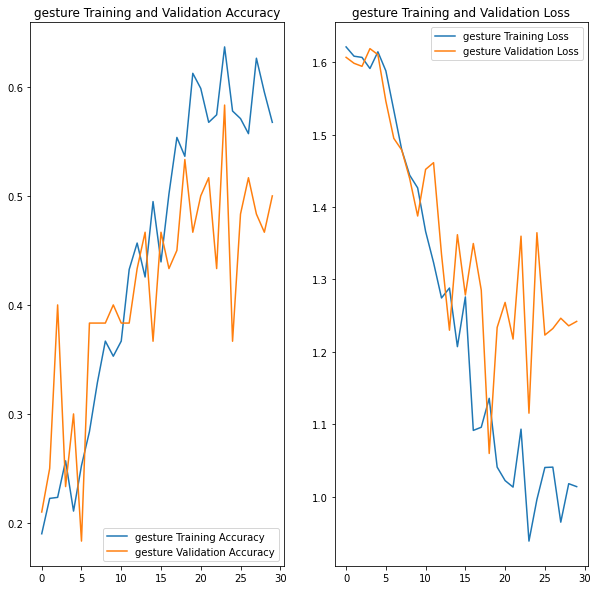

Max. Training Accuracy 0.6366782188415527
Max. Validaiton Accuracy 0.5833333134651184


In [37]:
#Declaring Accuracy
gesture_accuracy = model_5.history['categorical_accuracy']

gesture_valid_accuracy = model_5.history['val_categorical_accuracy']

#Declaring Loss
gesture_loss = model_5.history['loss']

gesture_valid_loss = model_5.history['val_loss']

epochs_range = range(num_epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,gesture_accuracy,label='gesture Training Accuracy')
plt.plot(epochs_range,gesture_valid_accuracy,label='gesture Validation Accuracy')
plt.legend(loc='lower right')
plt.title("gesture Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,gesture_loss,label='gesture Training Loss')
plt.plot(epochs_range,gesture_valid_loss,label='gesture Validation Loss')
plt.legend(loc='upper right')
plt.title("gesture Training and Validation Loss")

plt.show()

print("Max. Training Accuracy", max(model_5.history['categorical_accuracy']))
print("Max. Validaiton Accuracy", max(model_5.history['val_categorical_accuracy']))

<p><b>Final Verdicts :</b></p>
<p><b>Model : </b>Conv2D 5 layer + Dense 1 layer + LSTM</p>
<p><b>Verdict :</b>The above training accuracy is decent but fails in case of validation accuracy, this could be because the LSTM model used is very simple and introduction of more dense layers can help. </p>
<br>
<p><b>Performance Metrics :</b></p>
<ul>
    <li>Max Training Accuracy : 63%</li>
    <li>Max Validation Accuracy : 58%</li>
</ul>

#### Model 6 : (Conv2D 5 layer + GRU RNN 1 layer) ( Dropout : 25% ,  dense_nurons : 64, optimiser : ADAM , batch_size: 40, Augment: False)

In [38]:
# Let us experiment different x,y,z value in the CNN network and find tune all the image size & Hyperparameters later

x = 30 # number of frames
y = 120 # image width
z = 120 # image height

# Input all the images sequencial by building the layer with dropouts and batchnormalisation

model_6 = Sequential()       

model_6.add(TimeDistributed(Conv2D(16, (3, 3), input_shape=(x,y,z,3),padding='same',activation='relu')))
model_6.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model_6.add(TimeDistributed(Conv2D(32, (3,3), padding='same',activation='relu')))
model_6.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model_6.add(TimeDistributed(Conv2D(64, (3,3), padding='same',activation='relu')))
model_6.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model_6.add(TimeDistributed(Conv2D(128, (3,3), padding='same',activation='relu')))
model_6.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model_6.add(TimeDistributed(Conv2D(256, (3,3), padding='same',activation='relu')))
model_6.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Flatten layer 

model_6.add(TimeDistributed(Flatten()))

model_6.add(GRU(64))
model_6.add(Dropout(0.5))

model_6.add(Dense(64, activation='relu'))
model_6.add(Dropout(0.5))

#Softmax layer

model_6.add(Dense(5, activation='softmax'))

# Let us use the Adam optimiser 

optimiser = optimizers.Adam() #write your optimizer
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_6.build(input_shape=(30,30,160,160,3))
print (model_6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (30, 30, 160, 160, 16)    448       
_________________________________________________________________
time_distributed_12 (TimeDis (30, 30, 80, 80, 16)      0         
_________________________________________________________________
time_distributed_13 (TimeDis (30, 30, 80, 80, 32)      4640      
_________________________________________________________________
time_distributed_14 (TimeDis (30, 30, 40, 40, 32)      0         
_________________________________________________________________
time_distributed_15 (TimeDis (30, 30, 40, 40, 64)      18496     
_________________________________________________________________
time_distributed_16 (TimeDis (30, 30, 20, 20, 64)      0         
_________________________________________________________________
time_distributed_17 (TimeDis (30, 30, 20, 20, 128)    

In [39]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


In [40]:
model_6 = model_6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30,verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - 83s 5s/step - loss: 1.6209 - categorical_accuracy: 0.1736 - val_loss: 1.6056 - val_categorical_accuracy: 0.2300

Epoch 00001: val_categorical_accuracy did not improve from 0.86667
Epoch 2/30
17/17 [==============================] - 67s 4s/step - loss: 1.6028 - categorical_accuracy: 0.2078 - val_loss: 1.5813 - val_categorical_accuracy: 0.2333

Epoch 00002: val_categorical_accuracy did not improve from 0.86667
Epoch 3/30
17/17 [==============================] - 55s 3s/step - loss: 1.5854 - categorical_accuracy: 0.2337 - val_loss: 1.5112 - val_categorical_accuracy: 0.3333

Epoch 00003: val_categorical_accuracy did not improve from 0.86667
Epoch 4/30
17/17 [==============================] - 36s 2s/step - loss: 1.5244 - categorical_accuracy: 0.2674 - val_loss: 1.5181 - val_categorical_accuracy: 0.2500

Epoch 00004: val_categorical_accuracy did not improve from 0.86667
Epoch 5/30
17/17 [==============================] - 38s 2s/step - loss: 

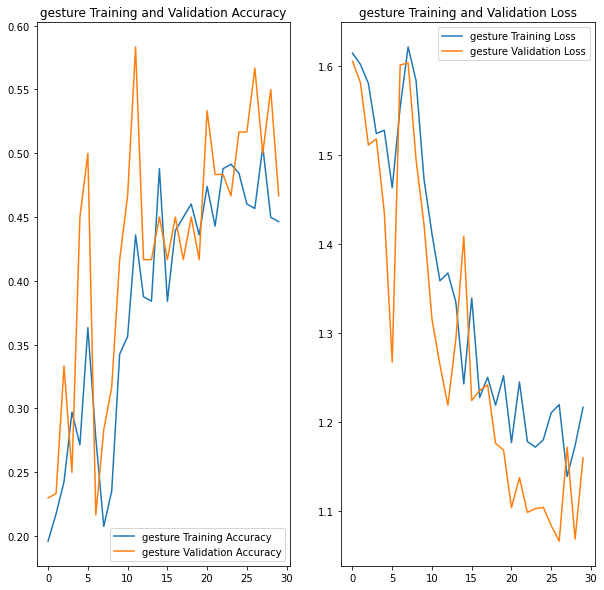

Max. Training Accuracy 0.5051903128623962
Max. Validaiton Accuracy 0.5833333134651184


In [42]:
#Declaring Accuracy
gesture_accuracy = model_6.history['categorical_accuracy']

gesture_valid_accuracy = model_6.history['val_categorical_accuracy']

#Declaring Loss
gesture_loss = model_6.history['loss']

gesture_valid_loss = model_6.history['val_loss']

epochs_range = range(num_epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,gesture_accuracy,label='gesture Training Accuracy')
plt.plot(epochs_range,gesture_valid_accuracy,label='gesture Validation Accuracy')
plt.legend(loc='lower right')
plt.title("gesture Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,gesture_loss,label='gesture Training Loss')
plt.plot(epochs_range,gesture_valid_loss,label='gesture Validation Loss')
plt.legend(loc='upper right')
plt.title("gesture Training and Validation Loss")

plt.show()

print("Max. Training Accuracy", max(model_6.history['categorical_accuracy']))
print("Max. Validaiton Accuracy", max(model_6.history['val_categorical_accuracy']))


<p><b>Final Verdicts :</b></p>
<p><b>Model : </b>Conv2D 5 layer + Dense 1 layer + GRU</p>
<p><b>Verdict :</b>The above training accuracy is less but fails in case of validation accuracy, this could be because the GRU model used is very simple and introduction of more dense layers can help. </p>
<br>
<p><b>Performance Metrics :</b></p>
<ul>
    <li>Max Training Accuracy : 50%</li>
    <li>Max Validation Accuracy : 58%</li>
</ul>

#### Generator with Data Augmentation

In [12]:
x = 30 # No. of frames images
y = 120 # Width of the image
z = 120 # height

def generatorWithAugmentation(source_path, folder_list, batch_size):
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Let us resize all the images 
                    
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-20,20)],[0, 1, np.random.randint(-20,20)]]),(image.shape[1], image.shape[0]))
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    resized_image = imresize(cropped,(y,z))
                    resized_image = resized_image.astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/127.5-1#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/127.5-1#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/127.5-1#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches        
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-20,20)],[0, 1, np.random.randint(-20,20)]]),(image.shape[1], image.shape[0]))
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    resized_image = imresize(cropped,(y,z))
                    resized_image = resized_image.astype(np.float32)
                                        
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/127.5-1
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/127.5-1
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/127.5-1
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

#### Model 7 : (Conv3D 1 layer + Dense 4 layer) ( Dropout : 50% and 25% ,  dense_nurons : (128,64) optimiser : Adam , batch_size: 40, Augment: True)

In [13]:
# Let us experiment different x,y,z value in the CNN network and find tune all the image size & Hyperparameters later

x = 30 # number of frames
y = 120 # image width
z = 120 # image height

# Input all the images sequencial by building the layer with dropouts
model_7 = Sequential()       

model_7.add(Conv3D(16, (3, 3, 3), input_shape=(x,y,z,3),padding='same'))
model_7.add(Activation('relu'))
model_7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_7.add(Conv3D(32, (2, 2, 2), padding='same'))
model_7.add(Activation('relu'))
model_7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_7.add(Conv3D(64, (2, 2, 2), padding='same'))
model_7.add(Activation('relu'))
model_7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_7.add(Conv3D(128, (2, 2, 2), padding='same'))
model_7.add(Activation('relu'))
model_7.add(MaxPooling3D(pool_size=(2, 2, 2)))      

# Flatten layer 

model_7.add(Flatten())

model_7.add(Dense(128, activation='relu'))
model_7.add(Dropout(0.5))

model_7.add(Dense(64, activation='relu'))
model_7.add(Dropout(0.25))

#Softmax layer

model_7.add(Dense(5, activation='softmax'))

# Let us use the Adam optimiser 

optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 30, 30, 64)     1

In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [18]:
train_generator_aug = generatorWithAugmentation(train_path, train_doc, batch_size)
val_generator_aug = generatorWithAugmentation(val_path, val_doc, batch_size)

In [19]:
# Let us fit the model
model_7.fit_generator(train_generator_aug, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_aug, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - 140s 8s/step - loss: 1.6265 - categorical_accuracy: 0.2120 - val_loss: 1.5654 - val_categorical_accuracy: 0.2900

Epoch 00001: val_categorical_accuracy improved from -inf to 0.29000, saving model to model_init_2022-04-2004_38_21.709949/model-00001-1.61064-0.21870-1.56540-0.29000.h5
Epoch 2/30
17/17 [==============================] - 78s 5s/step - loss: 1.5515 - categorical_accuracy: 0.2729 - val_loss: 1.5524 - val_categorical_accuracy: 0.1667

Epoch 00002: val_categorical_accuracy did not improve from 0.29000
Epoch 3/30
17/17 [==============================] - 69s 4s/step - loss: 1.5291 - categorical_accuracy: 0.3261 - val_loss: 1.5218 - val_categorical_accuracy: 0.2333

Epoch 00003: val_categorical_accuracy did not improve from 0.29000
Epoch 4/30
17/17 [==============================] - 66s 4s/step - loss: 1.4895 - categorical_accuracy: 0.3373 - val_loss: 1.4477 - val_categorical_accuracy: 0.3667

Epoch 00004: val_categorical_accurac

<p><b>Final Verdicts :</b></p>
<p><b>Model : </b>Conv3D 4  layer + Dense 1 layer with Augmentation</p>
<p><b>Verdict :</b>The training accuracy increases gradually throughout the model but fluctuates highly for validation accuracy, and this indicates it is not a stable model and would not perform well on unseen data.

Data augmentation increases the computation time and is not a suitable model. </p>
<br>
<p><b>Performance Metrics :</b></p>
<ul>
    <li>Max Training Accuracy : 72.16%</li>
    <li>Max Validation Accuracy : 76.67%</li>
</ul>

#### Model 8 : (Conv3D 4 layer + Dense 2 layer) ( Dropout : 25% ,  dense_nurons : (1000,500) optimiser : Adam , batch_size: 40, Augment: True)

In [22]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

model_8 = Sequential()       
#model_8.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(x,y,z,3),padding='same'))
#model_8.add(BatchNormalization())
#model_8.add(Activation('relu'))

model_8.add(Conv3D(16, (3, 3, 3),input_shape=(x,y,z,3), padding='same'))
model_8.add(Activation('relu'))
#model_8.add(BatchNormalization())
model_8.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_8.add(Dropout(0.25))

model_8.add(Conv3D(32, (2, 2, 2), padding='same'))
model_8.add(Activation('relu'))
#model_8.add(BatchNormalization())
model_8.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_8.add(Dropout(0.25))

model_8.add(Conv3D(64, (2, 2, 2), padding='same'))
model_8.add(Activation('relu'))
#model_8.add(BatchNormalization())
model_8.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_8.add(Dropout(0.25))

model_8.add(Conv3D(128, (2, 2, 2), padding='same'))
model_8.add(Activation('relu'))
#model_8.add(BatchNormalization())
model_8.add(MaxPooling3D(pool_size=(2, 2, 2)))    
model_8.add(Dropout(0.25))  

# Flatten layer 

model_8.add(Flatten())

model_8.add(Dense(1000, activation='relu',kernel_regularizer='l2'))
model_8.add(Dropout(0.25))

model_8.add(Dense(500, activation='relu',kernel_regularizer='l2'))
model_8.add(Dropout(0.25))

#Softmax layer

model_8.add(Dense(5, activation='softmax'))

# Let us use the RMSprop optimiser 

model_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_8.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_5 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 7, 30, 30, 32)    

In [23]:
model_8 = model_8.fit_generator(train_generator_aug, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_aug, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - 61s 4s/step - loss: 24.9931 - categorical_accuracy: 0.1604 - val_loss: 22.2109 - val_categorical_accuracy: 0.3833

Epoch 00001: val_categorical_accuracy did not improve from 0.76667
Epoch 2/30
17/17 [==============================] - 57s 4s/step - loss: 21.4476 - categorical_accuracy: 0.1758 - val_loss: 19.1674 - val_categorical_accuracy: 0.2167

Epoch 00002: val_categorical_accuracy did not improve from 0.76667
Epoch 3/30
17/17 [==============================] - 58s 4s/step - loss: 18.5215 - categorical_accuracy: 0.2179 - val_loss: 16.8663 - val_categorical_accuracy: 0.3833

Epoch 00003: val_categorical_accuracy did not improve from 0.76667
Epoch 4/30
17/17 [==============================] - 57s 4s/step - loss: 16.3555 - categorical_accuracy: 0.2709 - val_loss: 15.0861 - val_categorical_accuracy: 0.3000

Epoch 00004: val_categorical_accuracy did not improve from 0.76667
Epoch 5/30
17/17 [==============================] - 57s 4s/step 

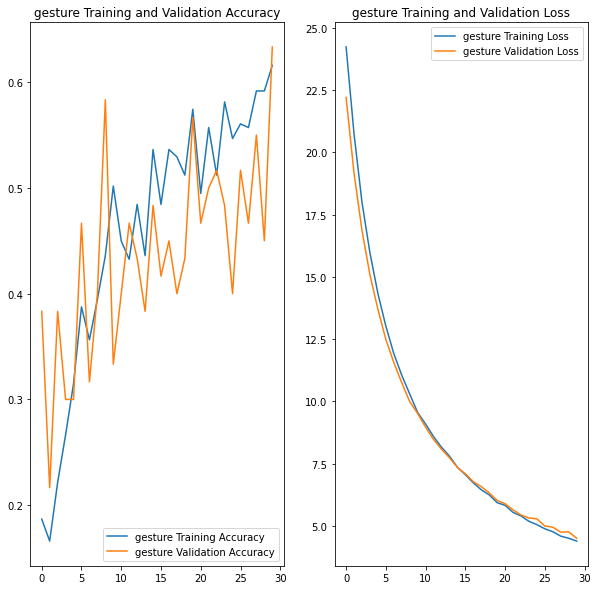

Max. Training Accuracy 0.6159169673919678
Max. Validaiton Accuracy 0.6333333253860474


In [24]:
#Declaring Accuracy
gesture_accuracy = model_8.history['categorical_accuracy']

gesture_valid_accuracy = model_8.history['val_categorical_accuracy']

#Declaring Loss
gesture_loss = model_8.history['loss']

gesture_valid_loss = model_8.history['val_loss']

epochs_range = range(num_epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,gesture_accuracy,label='gesture Training Accuracy')
plt.plot(epochs_range,gesture_valid_accuracy,label='gesture Validation Accuracy')
plt.legend(loc='lower right')
plt.title("gesture Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,gesture_loss,label='gesture Training Loss')
plt.plot(epochs_range,gesture_valid_loss,label='gesture Validation Loss')
plt.legend(loc='upper right')
plt.title("gesture Training and Validation Loss")

plt.show()

print("Max. Training Accuracy", max(model_8.history['categorical_accuracy']))
print("Max. Validaiton Accuracy", max(model_8.history['val_categorical_accuracy']))


<p><b>Final Verdicts :</b></p>
<p><b>Model : </b>Conv3D 4  layer + Dense 2 layer with Augmentation</p>
<p><b>Verdict :</b>The dropout layers increase the number of parameters that are assigned as 0 (dropping out 25% neurons in most of layers) and this underfits the model, as a result the model does not learn properly and it leads to a very poor accuracy.
Data augmentation increases the computation time and is not a suitable model. </p>
<br>
<p><b>Performance Metrics :</b></p>
<ul>
    <li>Max Training Accuracy : 61.59%</li>
    <li>Max Validation Accuracy : 63.33%</li>
</ul>

#### Model 9 : (Conv3D 1 layer + Dense 5 layer) ( Dropout : 25% ,  dense_nurons : (1000,500) optimiser : Adam , batch_size: 40, Augment: False)

In [25]:
model_9 = Sequential()       
model_9.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(x,y,z,3),padding='same'))
model_9.add(Activation('relu'))

model_9.add(Conv3D(16, (3, 3, 3), padding='same'))
model_9.add(Activation('relu'))
model_9.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_9.add(Conv3D(32, (2, 2, 2), padding='same'))
model_9.add(Activation('relu'))

model_9.add(Conv3D(32, (2, 2, 2), padding='same'))
model_9.add(Activation('relu'))
model_9.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_9.add(Conv3D(64, (2, 2, 2), padding='same'))
model_9.add(Activation('relu'))

model_9.add(Conv3D(64, (2, 2, 2), padding='same'))
model_9.add(Activation('relu'))
model_9.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_9.add(Conv3D(128, (2, 2, 2), padding='same'))
model_9.add(Activation('relu'))

model_9.add(Conv3D(128, (2, 2, 2), padding='same'))
model_9.add(Activation('relu'))
model_9.add(MaxPooling3D(pool_size=(2, 2, 2)))    

# Flatten layer 

model_9.add(Flatten())

model_9.add(Dense(1000, activation='relu',kernel_regularizer='l2'))
model_9.add(Dropout(0.25))

model_9.add(Dense(500, activation='relu',kernel_regularizer='l2'))
model_9.add(Dropout(0.25))

#Softmax layer

model_9.add(Dense(5, activation='softmax'))

# Let us use the Adam optimiser 

optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_9.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_8 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 30, 120, 120, 16)  3472      
_________________________________________________________________
activation_9 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 60, 60, 32)   

In [30]:
model_9 = model_9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - 70s 4s/step - loss: 20.8960 - categorical_accuracy: 0.2033 - val_loss: 9.5379 - val_categorical_accuracy: 0.2300

Epoch 00001: val_categorical_accuracy did not improve from 0.76667
Epoch 2/30
17/17 [==============================] - 41s 3s/step - loss: 7.8817 - categorical_accuracy: 0.1964 - val_loss: 4.6689 - val_categorical_accuracy: 0.3333

Epoch 00002: val_categorical_accuracy did not improve from 0.76667
Epoch 3/30
17/17 [==============================] - 39s 2s/step - loss: 4.1717 - categorical_accuracy: 0.2734 - val_loss: 3.1112 - val_categorical_accuracy: 0.3667

Epoch 00003: val_categorical_accuracy did not improve from 0.76667
Epoch 4/30
17/17 [==============================] - 35s 2s/step - loss: 2.8489 - categorical_accuracy: 0.3843 - val_loss: 2.5207 - val_categorical_accuracy: 0.1667

Epoch 00004: val_categorical_accuracy did not improve from 0.76667
Epoch 5/30
17/17 [==============================] - 35s 2s/step - loss:

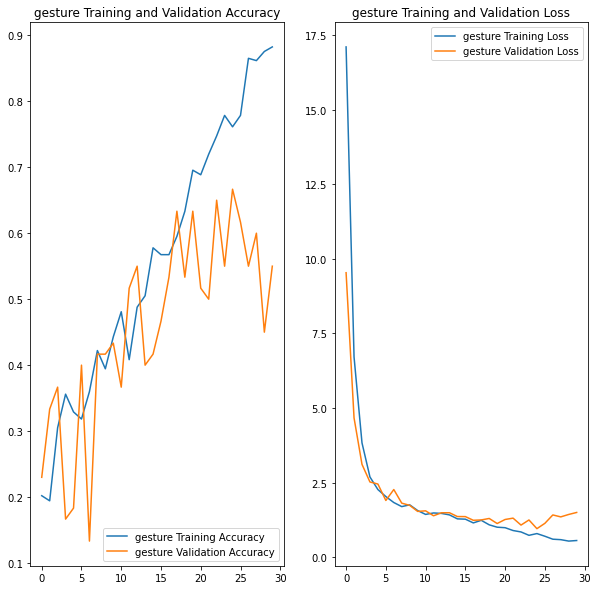

Max. Training Accuracy 0.8823529481887817
Max. Validaiton Accuracy 0.6666666865348816


In [31]:
#Declaring Accuracy
gesture_accuracy = model_9.history['categorical_accuracy']

gesture_valid_accuracy = model_9.history['val_categorical_accuracy']

#Declaring Loss
gesture_loss = model_9.history['loss']

gesture_valid_loss = model_9.history['val_loss']

epochs_range = range(num_epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,gesture_accuracy,label='gesture Training Accuracy')
plt.plot(epochs_range,gesture_valid_accuracy,label='gesture Validation Accuracy')
plt.legend(loc='lower right')
plt.title("gesture Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,gesture_loss,label='gesture Training Loss')
plt.plot(epochs_range,gesture_valid_loss,label='gesture Validation Loss')
plt.legend(loc='upper right')
plt.title("gesture Training and Validation Loss")

plt.show()

print("Max. Training Accuracy", max(model_9.history['categorical_accuracy']))
print("Max. Validaiton Accuracy", max(model_9.history['val_categorical_accuracy']))


<p><b>Final Verdicts :</b></p>
<p><b>Model : </b>Conv3D 5 layer + Dense 2 layer </p>
<p><b>Verdict :</b>The model is overfitting as well as complex.The foremost objective of training machine learning based model is to keep a good trade-off between simplicity of the model and the performance accuracy which is not achieved with this model. </p>
<br>
<p><b>Performance Metrics :</b></p>
<ul>
    <li>Max Training Accuracy : 88.2%</li>
    <li>Max Validation Accuracy : 66.66%</li>
</ul>



#### Model 10 : (Conv3D 1 layer + Dense 5 layer) ( Dropout : 25% ,  dense_nurons : 256 optimiser : Adam , batch_size: 40, Augment: True)

In [32]:
# Let us experiment different x,y,z value in the CNN network and find tune all the image size & Hyperparameters later

x = 30 # number of frames
y = 120 # image width
z = 120 # image height

# Input all the images sequencial by building the layer with dropouts

model_10 = Sequential()       
model_10.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(x,y,z,3),padding='same'))
model_10.add(Activation('relu'))

model_10.add(Conv3D(16, (3, 3, 3), padding='same'))
model_10.add(Activation('relu'))
model_10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_10.add(Conv3D(32, (2, 2, 2), padding='same'))
model_10.add(Activation('relu'))
model_10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_10.add(Conv3D(64, (2, 2, 2), padding='same'))
model_10.add(Activation('relu'))
model_10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_10.add(Conv3D(128, (2, 2, 2), padding='same'))
model_10.add(Activation('relu'))
model_10.add(MaxPooling3D(pool_size=(2, 2, 2)))      

# Flatten layer 

model_10.add(Flatten())

model_10.add(Dense(256, activation='relu',kernel_regularizer='l2'))
model_10.add(Dropout(0.25))

model_10.add(Dense(256, activation='relu',kernel_regularizer='l2'))
model_10.add(Dropout(0.25))

#Softmax layer

model_10.add(Dense(5, activation='softmax'))

# Let us use the Adam optimiser 

optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_10.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_15 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 30, 120, 120, 16)  3472      
_________________________________________________________________
activation_16 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_17 (Activation)   (None, 15, 60, 60, 32)   

In [33]:
model_10 = model_10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - 32s 2s/step - loss: 7.5330 - categorical_accuracy: 0.2360 - val_loss: 4.2538 - val_categorical_accuracy: 0.2167

Epoch 00001: val_categorical_accuracy did not improve from 0.76667
Epoch 2/30
17/17 [==============================] - 32s 2s/step - loss: 3.7933 - categorical_accuracy: 0.2572 - val_loss: 2.8289 - val_categorical_accuracy: 0.3500

Epoch 00002: val_categorical_accuracy did not improve from 0.76667
Epoch 3/30
17/17 [==============================] - 31s 2s/step - loss: 2.6365 - categorical_accuracy: 0.3119 - val_loss: 2.1753 - val_categorical_accuracy: 0.3667

Epoch 00003: val_categorical_accuracy did not improve from 0.76667
Epoch 4/30
17/17 [==============================] - 34s 2s/step - loss: 1.9784 - categorical_accuracy: 0.4515 - val_loss: 1.7579 - val_categorical_accuracy: 0.5333

Epoch 00004: val_categorical_accuracy did not improve from 0.76667
Epoch 5/30
17/17 [==============================] - 31s 2s/step - loss: 

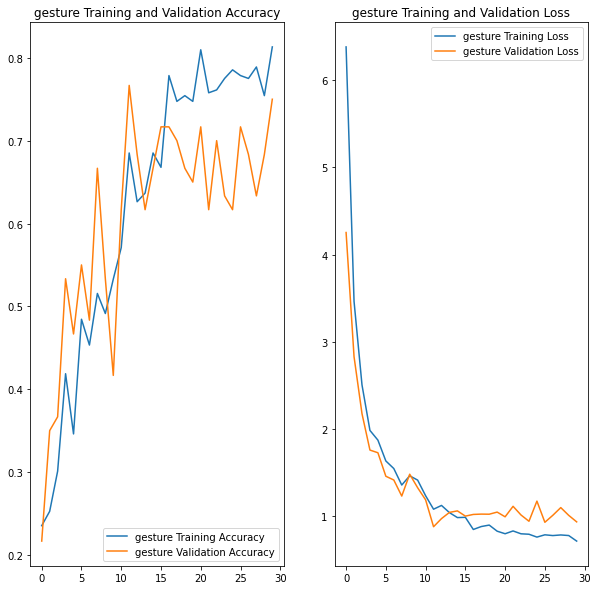

Max. Training Accuracy 0.8131487965583801
Max. Validaiton Accuracy 0.7666666507720947


In [34]:
#Declaring Accuracy
gesture_accuracy = model_10.history['categorical_accuracy']

gesture_valid_accuracy = model_10.history['val_categorical_accuracy']

#Declaring Loss
gesture_loss = model_10.history['loss']

gesture_valid_loss = model_10.history['val_loss']

epochs_range = range(num_epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,gesture_accuracy,label='gesture Training Accuracy')
plt.plot(epochs_range,gesture_valid_accuracy,label='gesture Validation Accuracy')
plt.legend(loc='lower right')
plt.title("gesture Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,gesture_loss,label='gesture Training Loss')
plt.plot(epochs_range,gesture_valid_loss,label='gesture Validation Loss')
plt.legend(loc='upper right')
plt.title("gesture Training and Validation Loss")

plt.show()

print("Max. Training Accuracy", max(model_10.history['categorical_accuracy']))
print("Max. Validaiton Accuracy", max(model_10.history['val_categorical_accuracy']))


<p><b>Final Verdicts :</b></p>
<p><b>Model : </b>Conv3D 5 layer + Dense 2 layer </p>
<p><b>Verdict :</b>The model is good</p>
<br>
<p><b>Performance Metrics :</b></p>
<ul>
    <li>Max Training Accuracy : 81.3%</li>
    <li>Max Validation Accuracy : 76.6%</li>
</ul>



### Transfer Learning

#### Model 11 : (Transfer Learning + Dense 1  layer + LSTM) ( Dropout : 25% ,  dense_nurons : (128,120) optimiser : Adam , batch_size: 40, Augment: True)

In [35]:
from tensorflow.keras.applications import mobilenet

In [36]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


In [37]:
x = 30
y = 120
z = 120

model_tl = Sequential()
model_tl.add(TimeDistributed(mobilenet_transfer,input_shape=(x,y,z,3)))

for layer in model_tl.layers:
    layer.trainable = False

model_tl.add(TimeDistributed(MaxPooling2D((2,2))))
model_tl.add(TimeDistributed(Flatten()))

model_tl.add(LSTM(128))
model_tl.add(Dropout(0.25))

model_tl.add(Dense(120,activation='relu',kernel_regularizer='l2'))
model_tl.add(Dropout(0.25))

model_tl.add(Dense(5, activation='softmax',kernel_regularizer='l2'))

optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_tl.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_tl.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               590336    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)               15480     
_________________________________________________________________
dropout_13 (Dropout)         (None, 120)              

In [38]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [39]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [40]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [41]:
model_tl = model_tl.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - 39s 2s/step - loss: 2.9409 - categorical_accuracy: 0.2311 - val_loss: 2.5644 - val_categorical_accuracy: 0.5500

Epoch 00001: val_categorical_accuracy improved from -inf to 0.55000, saving model to model_init_2022-04-2004_38_21.709949/model-00001-2.83280-0.29563-2.56438-0.55000.h5
Epoch 2/30
17/17 [==============================] - 21s 1s/step - loss: 2.4828 - categorical_accuracy: 0.4173 - val_loss: 2.2395 - val_categorical_accuracy: 0.5833

Epoch 00002: val_categorical_accuracy improved from 0.55000 to 0.58333, saving model to model_init_2022-04-2004_38_21.709949/model-00002-2.42188-0.44501-2.23947-0.58333.h5
Epoch 3/30
17/17 [==============================] - 21s 1s/step - loss: 2.1773 - categorical_accuracy: 0.5279 - val_loss: 1.9707 - val_categorical_accuracy: 0.5333

Epoch 00003: val_categorical_accuracy did not improve from 0.58333
Epoch 4/30
17/17 [==============================] - 18s 1s/step - loss: 1.9669 - categorical_accu

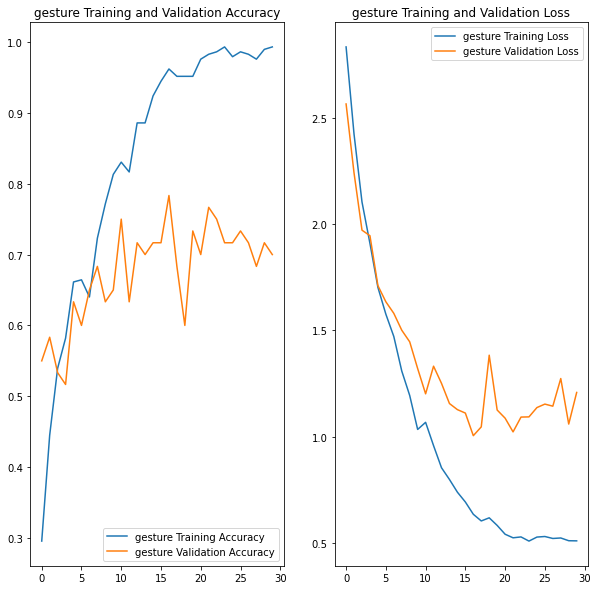

Max. Training Accuracy 0.9930796027183533
Max. Validaiton Accuracy 0.7833333611488342


In [42]:
#Declaring Accuracy
gesture_accuracy = model_tl.history['categorical_accuracy']

gesture_valid_accuracy = model_tl.history['val_categorical_accuracy']

#Declaring Loss
gesture_loss = model_tl.history['loss']

gesture_valid_loss = model_tl.history['val_loss']

epochs_range = range(num_epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,gesture_accuracy,label='gesture Training Accuracy')
plt.plot(epochs_range,gesture_valid_accuracy,label='gesture Validation Accuracy')
plt.legend(loc='lower right')
plt.title("gesture Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,gesture_loss,label='gesture Training Loss')
plt.plot(epochs_range,gesture_valid_loss,label='gesture Validation Loss')
plt.legend(loc='upper right')
plt.title("gesture Training and Validation Loss")

plt.show()

print("Max. Training Accuracy", max(model_tl.history['categorical_accuracy']))
print("Max. Validaiton Accuracy", max(model_tl.history['val_categorical_accuracy']))


<p><b>Final Verdicts :</b></p>
<p><b>Model : </b>Transfer Learning with LSTM </p>
<p><b>Verdict :</b>The model is overfitting as well as complex.The foremost objective of training machine learning based model is to keep a good trade-off between simplicity of the model and the performance accuracy which is not achieved with this model. </p>
<br>
<p><b>Performance Metrics :</b></p>
<ul>
    <li>Max Training Accuracy : 99.3%</li>
    <li>Max Validation Accuracy : 78.6%</li>
</ul>



#### Model 12 : (Transfer Learning + Dense 1  layer + GRU ) ( Dropout : 25% ,  dense_nurons : 128 optimiser : Adam , batch_size: 40, Augment: True)

In [51]:
x = 16
y = 120
z = 120

model_tl_1 = Sequential()
model_tl_1.add(TimeDistributed(mobilenet_transfer,input_shape=(x,y,z,3)))
 
        
#model_tl_1.add(TimeDistributed(BatchNormalization()))
model_tl_1.add(TimeDistributed(MaxPooling2D((2, 2))))
model_tl_1.add(TimeDistributed(Flatten()))

model_tl_1.add(GRU(128))
model_tl_1.add(Dropout(0.25))
        
model_tl_1.add(Dense(128,activation='relu'))
model_tl_1.add(Dropout(0.25))
        
model_tl_1.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_tl_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_tl_1.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_15 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)              

In [52]:
model_tl_1 = model_tl_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - 21s 1s/step - loss: 1.8025 - categorical_accuracy: 0.2338 - val_loss: 1.5172 - val_categorical_accuracy: 0.3833

Epoch 00001: val_categorical_accuracy did not improve from 0.78333
Epoch 2/30
17/17 [==============================] - 18s 1s/step - loss: 1.5438 - categorical_accuracy: 0.3181 - val_loss: 1.3133 - val_categorical_accuracy: 0.4833

Epoch 00002: val_categorical_accuracy did not improve from 0.78333
Epoch 3/30
17/17 [==============================] - 17s 1s/step - loss: 1.4049 - categorical_accuracy: 0.3894 - val_loss: 1.2829 - val_categorical_accuracy: 0.5500

Epoch 00003: val_categorical_accuracy did not improve from 0.78333
Epoch 4/30
17/17 [==============================] - 18s 1s/step - loss: 1.4212 - categorical_accuracy: 0.3860 - val_loss: 1.1271 - val_categorical_accuracy: 0.6333

Epoch 00004: val_categorical_accuracy did not improve from 0.78333
Epoch 5/30
17/17 [==============================] - 18s 1s/step - loss: 

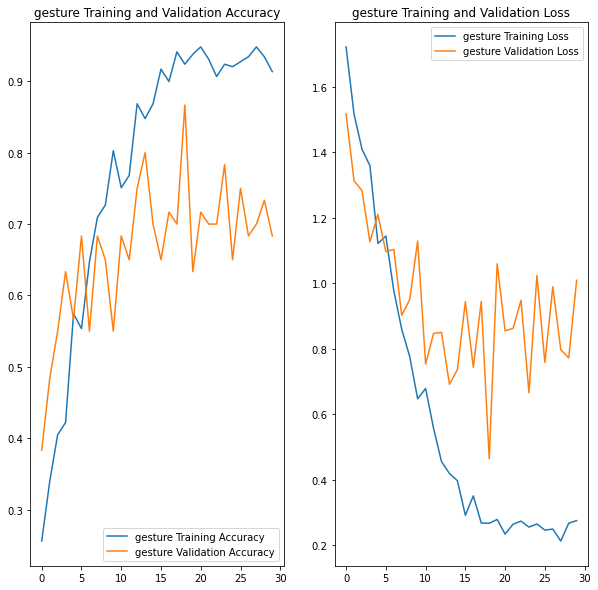

Max. Training Accuracy 0.9480968713760376
Max. Validaiton Accuracy 0.8666666746139526


In [53]:
#Declaring Accuracy
gesture_accuracy = model_tl_1.history['categorical_accuracy']

gesture_valid_accuracy = model_tl_1.history['val_categorical_accuracy']

#Declaring Loss
gesture_loss = model_tl_1.history['loss']

gesture_valid_loss = model_tl_1.history['val_loss']

epochs_range = range(num_epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,gesture_accuracy,label='gesture Training Accuracy')
plt.plot(epochs_range,gesture_valid_accuracy,label='gesture Validation Accuracy')
plt.legend(loc='lower right')
plt.title("gesture Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,gesture_loss,label='gesture Training Loss')
plt.plot(epochs_range,gesture_valid_loss,label='gesture Validation Loss')
plt.legend(loc='upper right')
plt.title("gesture Training and Validation Loss")

plt.show()

print("Max. Training Accuracy", max(model_tl_1.history['categorical_accuracy']))
print("Max. Validaiton Accuracy", max(model_tl_1.history['val_categorical_accuracy']))


<p><b>Final Verdicts :</b></p>
<p><b>Model : </b>Transfers Learning + GRU </p>
<p><b>Verdict :</b>The train and test accuracy are having more difference which leads to overfitting</p>
<br>
<p><b>Performance Metrics :</b></p>
<ul>
    <li>Max Training Accuracy : 94.2%</li>
    <li>Max Validation Accuracy : 86.66%</li>
</ul>



### Conclusion

Here **Conv3D** and **Transfers Learning** are getting good accuracy where generator with augmentation also gets good accuracy but with more computation time